In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import json, os
import pandas as pd
import seaborn as sns

## Authentication

In [2]:
with open("config.json") as f:
    config = json.load(f)

In [3]:
SPOTIPY_CLIENT_ID=config['client_id']
SPOTIPY_CLIENT_SECRET=config['client_secret']

In [4]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Understanding the API

In [5]:
lofi_hip_hop_music = 'spotify:playlist:3LFIBdP7eZXJKqf3guepZ1'

In [28]:
feature_columns = ['danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence']

In [52]:
sp.playlist_tracks(lofi_hip_hop_music,limit=100)['items'][0]['track']['id']

'3LUnxvWq1LNYHvuoXz9k9L'

In [ ]:
spotify:track:45s6KD7U23bk5Wn2D0XTHN

In [92]:
sp.artist('3rIZMv9rysU7JkLzEaC5Jp')['genres'][0]

'irish rock'

In [93]:
sp.artist(sp.track('45s6KD7U23bk5Wn2D0XTHN')['artists'][0]['id'])['genres'][0]

'irish rock'

In [84]:
sp.album('2YDBLlsC6og1bt9oIddktl')['genres']

[]

In [89]:
sp.track('45s6KD7U23bk5Wn2D0XTHN')['artists'][0]['id']

'3rIZMv9rysU7JkLzEaC5Jp'

## Creating functions

In [99]:
def playlist_audio_features_to_df(playlist_uri):
    #todo: add more than 100 songs to the playlist
    #todo: add genre
    df = pd.DataFrame()
    for track in sp.playlist_tracks(playlist_uri,limit=100)['items']:
        track_id = track['track']['id']
        popularity = sp.track(track_id)['popularity']

        dict_ = sp.audio_features(track_id)
        df_temp = pd.DataFrame(dict_)
        df_temp['popularity'] = popularity

        df = df.append(df_temp,ignore_index=True)
    
    #remove non numeric columns
    df_numeric = df.select_dtypes(include=['float64','int64'])
    df_only_audio_features = df[feature_columns]
    
    return df,df_numeric,df_only_audio_features

In [168]:
def get_playlist_uris(query,limit):
    
    playlists = []
    
    items = sp.search(query,limit=limit,type='playlist',market='NO')['playlists']['items']
    for item in items:
        id_ = item['id']
        playlists.append(id_)
    
    return playlists

In [185]:
def average_playlist_values(playlist_uris,verbose=False):
    df = pd.DataFrame()
    
    for playlist in playlist_uris:
        if verbose:
            print(playlist)
        _,track_numeric_df,_ = playlist_audio_features_to_df(playlist)
        mean_df = track_numeric_df.agg('mean')
        mean_df = mean_df.add_suffix('_mean')
        mean_df['playlist_uri'] = playlist
        mean_df['playlist_name'] = sp.playlist(playlist)['name']
        std_df = track_numeric_df.agg('std')
        std_df = std_df.add_suffix('_std')
        agg = pd.concat([mean_df, std_df], axis=0)
        
        df = df.append(agg,ignore_index=True)
        
    return df

In [178]:
df, df_numeric,df_audio_features  = playlist_audio_features_to_df(lofi_hip_hop_music)

KeyboardInterrupt: 

In [186]:
playlist_df = average_playlist_values(get_playlist_uris('lofi beats',2))

In [187]:
playlist_df

,acousticness_mean,acousticness_std,danceability_mean,danceability_std,duration_ms_mean,duration_ms_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,...,popularity_mean,popularity_std,speechiness_mean,speechiness_std,tempo_mean,tempo_std,time_signature_mean,time_signature_std,valence_mean,valence_std
0,0.661250,0.322989,0.55208,0.131542,112036.72,21817.848699,0.171857,0.108866,0.864420,0.122175,...,34.91,9.499702,0.103546,0.109740,105.12761,34.482548,3.89,0.423907,0.224457,0.177265
1,0.664605,0.282461,0.67391,0.110154,133153.06,36147.910220,0.266060,0.125120,0.739274,0.271691,...,47.11,17.648015,0.158331,0.156712,104.69087,37.800858,3.98,0.200000,0.369980,0.233520


## Plotting

<AxesSubplot:>

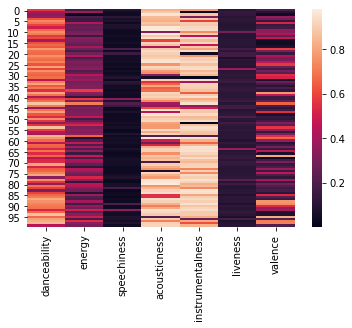

In [27]:
sns.heatmap(df.drop(['duration_ms','tempo','loudness','key','mode','time_signature'],axis=1))

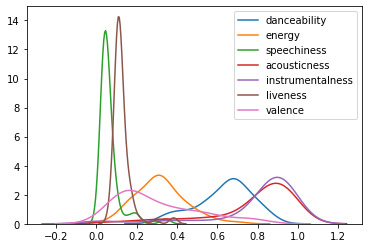

In [49]:
for column in df_audio_features.columns:
    sns.kdeplot(df_audio_features[column])